In [77]:
import numpy as np 
import pandas as pd 
import seaborn as sns 

## **Exercise: Imbalance Classification**
### **Feature Information**

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
-smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [78]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## **1. Business Understanding & Load Dataset**

As a data scientist at a renowned hospital, we are tasked with predicting whether an individual is at risk of experiencing a stroke.

Goals :<br>
Building a model to determine whether someone is at risk of having a stroke based on previous patient data.

False Positive:<br>

- An individual is diagnosed as being at risk for a stroke when they are not.<br>
- This can lead to the patient being prescribed unnecessary medication.<br>
- Consumer trust will decrease, and the risk of malpractice increases, damaging the hospital's reputation.<br>
- Difficult to quantify because it is intangible.<br>

False Negative:<br>

- An individual is not diagnosed as having a stroke when they actually do.
- This can prevent early intervention for the patient.
- Consumer trust will decrease.

Since both of these outcomes are sensitive, we will use a scoring method focused on minimizing both errors. Therefore, we will use the F1-score.

In [79]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [81]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [82]:
# Find duplicate values
df.duplicated().sum()

0

In [83]:
# Drop unnecessary column
df = df.drop(columns='id')

In [84]:
# Find missing values 
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [85]:
df[df['bmi'].isna()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


Missing values in df['bmi'] will be filled using KNN and we will define it in preprocessing

## **2. EDA**

In [86]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [87]:
# Divide categoric feature and numeric feature 
kategorik = []
numerik = []
for i in df.columns :
    if df[i].dtype == 'object':
        kategorik.append(i)
    else : 
        numerik.append(i)


In [88]:
df_kategorik = df[kategorik]
df_numerik = df[numerik]

In [89]:
df_numerik.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [90]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### **Histogram**

Text(0.5, 0, 'bmi')

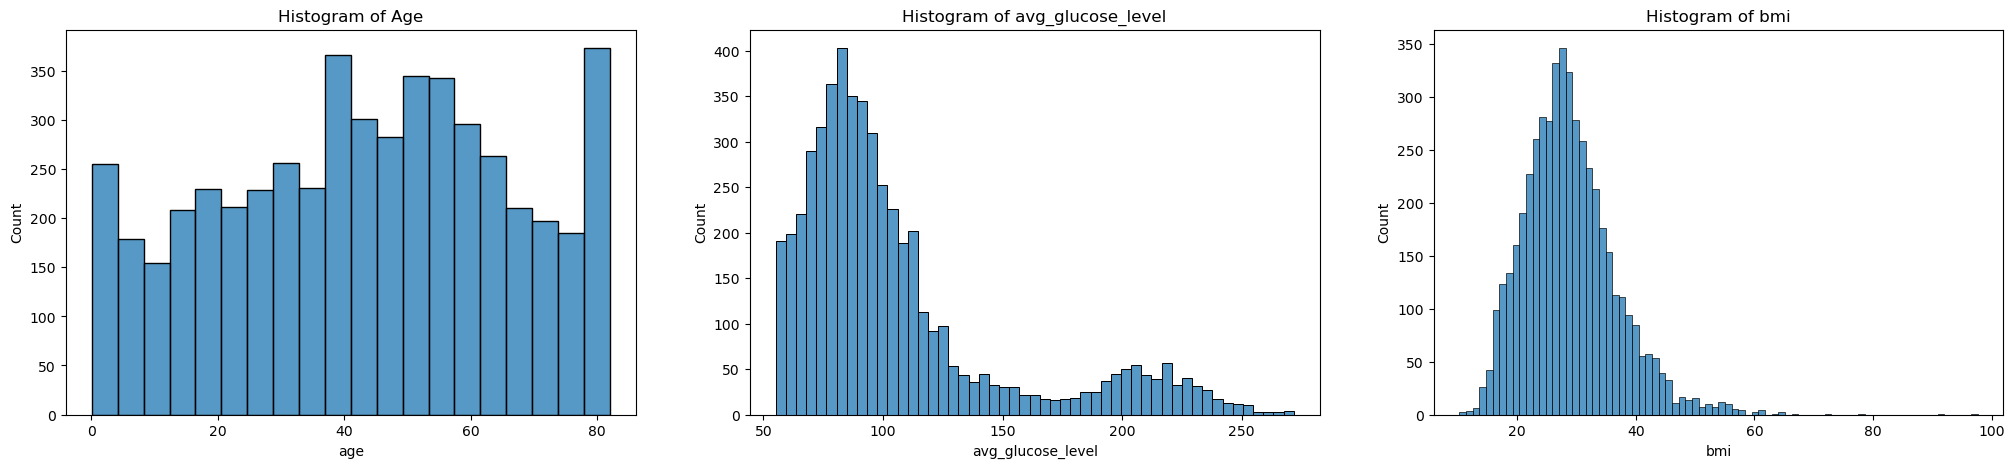

In [91]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.histplot(data=df,x='age')
plt.title('Histogram of Age')
plt.xlabel('age')

plt.subplot(1,3,2)
sns.histplot(data=df,x='avg_glucose_level')
plt.title('Histogram of avg_glucose_level')
plt.xlabel('avg_glucose_level')

plt.subplot(1,3,3)
sns.histplot(data=df,x='bmi')
plt.title('Histogram of bmi')
plt.xlabel('bmi')

The data for all numeric features are not normally distributed, so for further statistical tests and related metrics, we will use methods that meet this requirement.

### **Boxplot**

Text(0.5, 0, 'bmi')

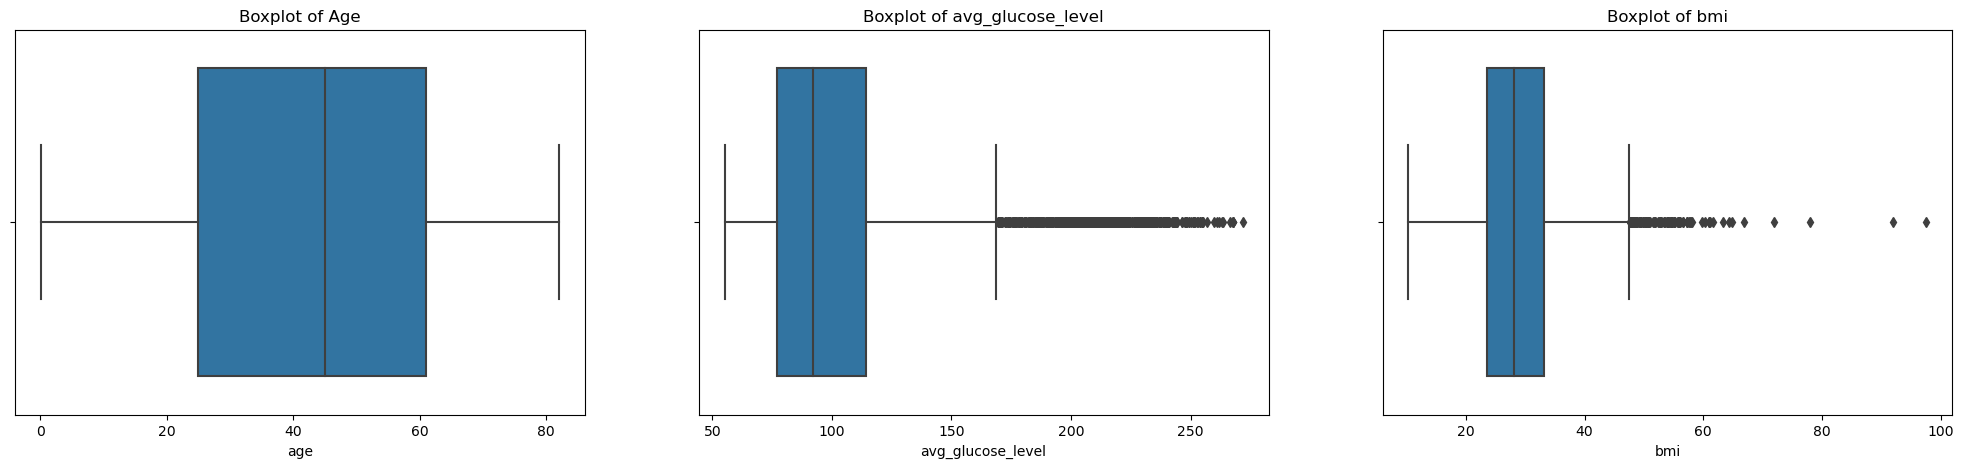

In [92]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.boxplot(data=df,x='age')
plt.title('Boxplot of Age')
plt.xlabel('age')

plt.subplot(1,3,2)
sns.boxplot(data=df,x='avg_glucose_level')
plt.title('Boxplot of avg_glucose_level')
plt.xlabel('avg_glucose_level')

plt.subplot(1,3,3)
sns.boxplot(data=df,x='bmi')
plt.title('Boxplot of bmi')
plt.xlabel('bmi')

In [93]:
df[df['bmi']>65]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
1559,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


From the boxplot above, i will delete df['bmi] that exceed 65. This has the reason because people that has high BMI are resulted in high risk of different illness. In this analyiss i would like to focus on the group that has normal bmi . Else of that, the number of people that has value above 65 only 5 person, so i could see very little and i am afraid it will affect the other data. 

In [94]:
df = df[~(df['bmi']>65)]
df.shape

(5105, 11)

Text(0.5, 0, 'bmi')

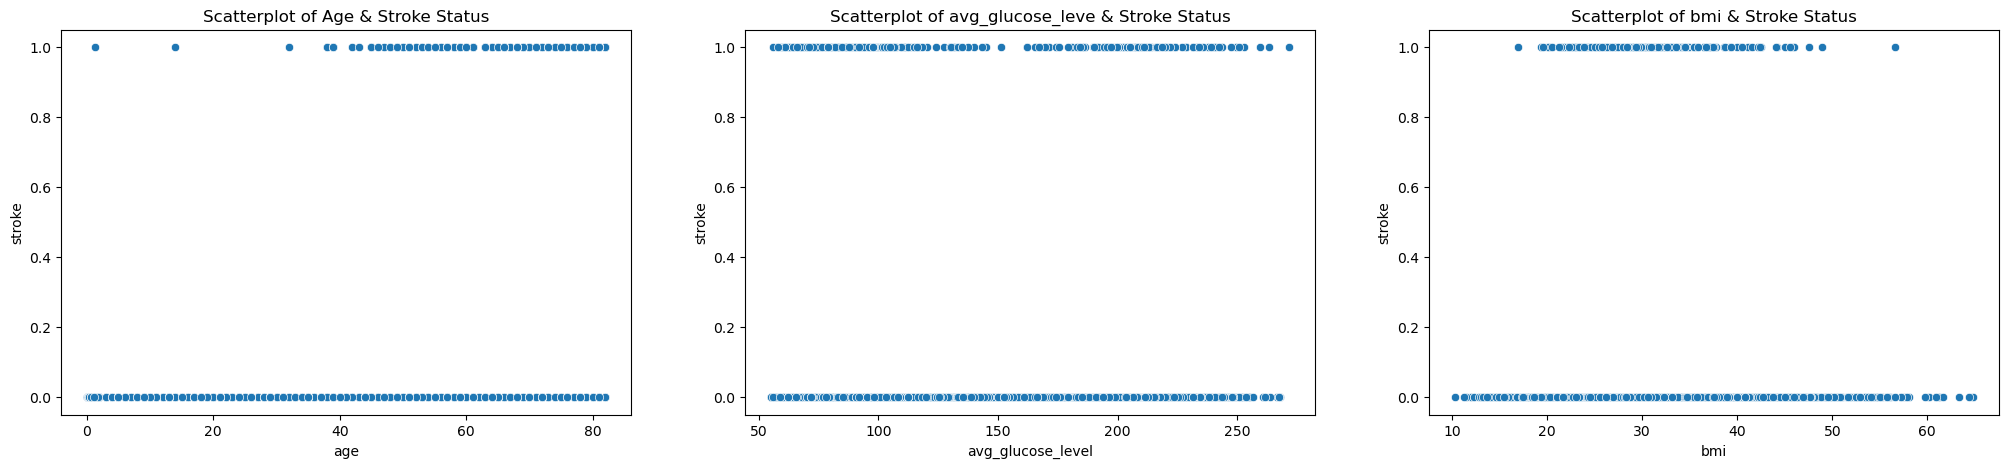

In [95]:
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
sns.scatterplot(data=df,x='age',y='stroke')
plt.title('Scatterplot of Age & Stroke Status')
plt.xlabel('age')

plt.subplot(1,3,2)
sns.scatterplot(data=df,x='avg_glucose_level',y='stroke')
plt.title('Scatterplot of avg_glucose_leve & Stroke Status')
plt.xlabel('avg_glucose_level')

plt.subplot(1,3,3)
sns.scatterplot(data=df,x='bmi',y='stroke')
plt.title('Scatterplot of bmi & Stroke Status')
plt.xlabel('bmi')


In [96]:
df_kategorik.head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [97]:
for i in df_kategorik.columns :
    print(i)
    print(df[i].unique())
    print('-------------------------')

gender
['Male' 'Female' 'Other']
-------------------------
ever_married
['Yes' 'No']
-------------------------
work_type
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
-------------------------
Residence_type
['Urban' 'Rural']
-------------------------
smoking_status
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
-------------------------


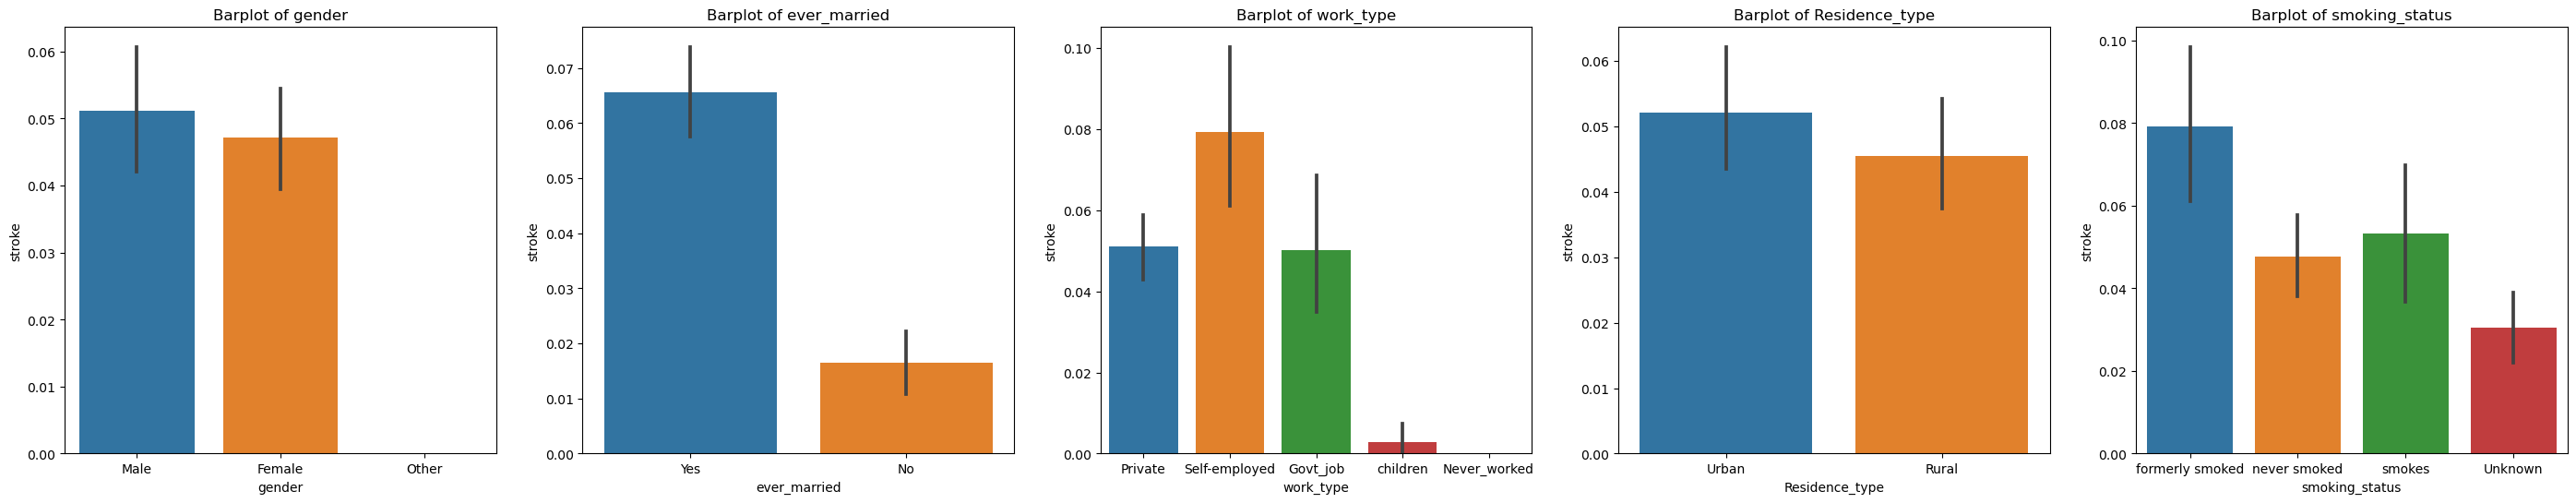

In [98]:
plt.figure(figsize=(35,6))
subplot = 1

for i in df_kategorik.columns : 
    plt.subplot(1,5,subplot)
    sns.barplot(data=df,x=i,y='stroke')
    plt.title(f'Barplot of {i}')
    plt.ylabel('stroke')
    plt.xlabel(i)
    subplot+=1

Using this visualization, I noticed that the gender and work_type features contain data labeled 'other' and 'never_worked,' which have very low counts. I will investigate further and decide whether to drop these entries.

Most of the users in this dataset are married, currently working, and formerly smoked. There is a good diversity of data from both urban and rural areas.

In [99]:
df[df['gender']=='Other']

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [100]:
# Delete the entries with the gender value "other" and the work type "never worked" because the data for these categories is very small.
df = df[~((df['gender']=='Other') | (df['work_type']=='Never_worked')) ]

In [101]:
# Change smoking status that 'Unknown' into missing value
df['smoking_status']=np.where(df['smoking_status']=='Unknown',np.NaN, df['smoking_status'])

In [102]:
df.isna().sum()

gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   201
smoking_status       1534
stroke                  0
dtype: int64

In [103]:
df[df['smoking_status'].isna()]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,NaN,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,NaN,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,NaN,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,NaN,1
23,Male,82.0,0,1,Yes,Private,Rural,208.30,32.5,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
5098,Male,9.0,0,0,No,children,Urban,71.88,17.5,NaN,0
5101,Female,45.0,0,0,Yes,Private,Urban,97.95,24.5,NaN,0
5103,Female,18.0,0,0,No,Private,Urban,82.85,46.9,NaN,0
5104,Female,13.0,0,0,No,children,Rural,103.08,18.6,NaN,0


Text(0.5, 1.0, 'Count of work_type')

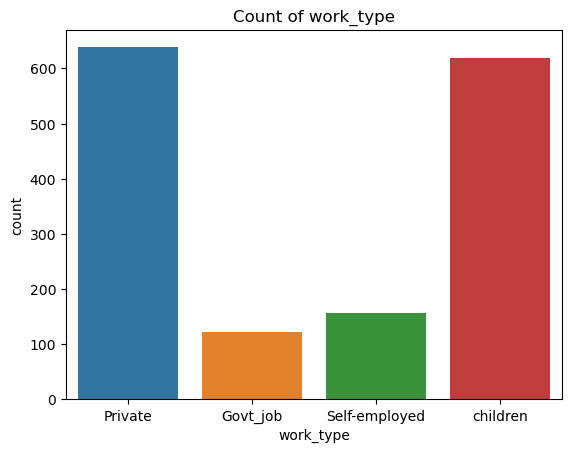

In [104]:
sns.countplot(data=df[df['smoking_status'].isna()], x='work_type')
plt.title('Count of work_type')

After changing the smoking status "unknown" to a missing value, I examined the work type and found some entries labeled as children. Since it is unlikely that children can smoke, I decided to fill the missing values in the smoking status for children with "never smoked."

In [148]:
df['smoking_status'] = np.where((df['smoking_status'].isna()) & (df['work_type'] == 'children'), 'never smoked', df['smoking_status'])


After this, all the missing value in df['smoking_status'] will be filled with mode 

In [106]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


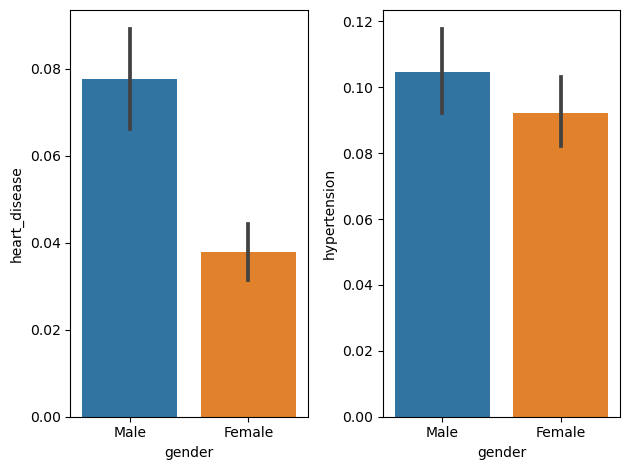

In [107]:
fid, ax = plt.subplots(1, 2)

ax1 = sns.barplot(data=df, x='gender', y='heart_disease', ax=ax[0])
ax2 = sns.barplot(data=df, x='gender', y='hypertension', ax=ax[1])

plt.tight_layout()

In [149]:
df['gender'].value_counts()/len(df)

gender
Female    0.58658
Male      0.41342
Name: count, dtype: float64

From this countplot, males have a higher number of heart disease and hypertension cases. 


## **3. Define X and y**

In [108]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


<Axes: xlabel='avg_glucose_level', ylabel='bmi'>

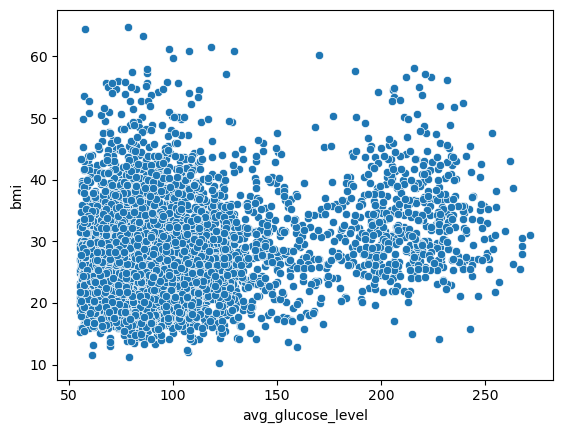

In [109]:
sns.scatterplot(data=df, x='avg_glucose_level',y='bmi')


In [110]:
X = df.drop(columns='stroke')
y = df['stroke']

In [111]:
y.value_counts() / len(X)*100

stroke
0    95.100354
1     4.899646
Name: count, dtype: float64

The data are imbalanced and will require treatment for imbalance.

## **4. Train, test and split**

In [112]:
X_train, X_test, y_train,  y_test = train_test_split( X, y, test_size=0.3, random_state= 0, stratify=y)

## **5. Data Preprocessing**

**Missing Values** 

simpleimputer : 'smoking_status' 

knn : 'bmi'

**encoding**

oneHotEncoding : 'gender','ever_married','work_type','Residence_type'

**scaling**

robustscale : 'age','avg_glucose_level'

In [113]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [114]:
mode_oneHot = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('modeOneHot',OneHotEncoder(drop='first'))
])

In [115]:
knnImpute_robust = Pipeline([
    ('knnImpute',KNNImputer(weights='distance')),
    ('robustKnn',RobustScaler())
])

In [116]:
transformer = ColumnTransformer([
    ('mode_oneHot',mode_oneHot,['smoking_status']),
    ('knnImpute_robust',knnImpute_robust,['bmi']),
    ('encoding',OneHotEncoder(drop ='first'),['gender','ever_married','work_type','Residence_type']),
    ('robustscale', RobustScaler(),['age','avg_glucose_level'])
], remainder='passthrough')

In [117]:
y.value_counts()

stroke
0    4833
1     249
Name: count, dtype: int64

## **6. Cross Validation**

### **a. Experiment 1 with Basic Algorithm and Scoring with f1**

In [118]:
# define loop untuk algorithm
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

In [119]:
from sklearn.model_selection import StratifiedKFold
list_algo = [logreg,knn,tree]
list_all_acc = []
list_mean_acc = []
list_std_acc =[]

for algo in list_algo :
    # pipeline 
    pipe_model = Pipeline([
    ('preprocessing',transformer),
    ('modeling', algo )
    ])

    # define kfold 
    fold = StratifiedKFold(n_splits=5) 

    # For classification, you can use StratifiedKFold.
    # For regression, you can use KFold as stratification is not necessary

    crossval = cross_val_score(estimator=pipe_model, # model 
                X = X_train,
                y = y_train,
                cv = fold, 
                scoring = 'f1')  
    
    # accuracy 
    list_all_acc.append(crossval.round(5))
    list_mean_acc.append(crossval.mean())
    list_std_acc.append(crossval.std())

In [120]:
df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['all_score'] = list_all_acc
df_cv['mean'] = list_mean_acc
df_cv['std']= list_std_acc

df_cv

,algo,all_score,mean,std
0,LogisticRegression(random_state=0),"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000,0.000000
1,KNeighborsClassifier(),"[0.05263, 0.0, 0.0, 0.10256, 0.0]",0.031039,0.041164
2,DecisionTreeClassifier(random_state=0),"[0.23377, 0.16216, 0.22222, 0.21053, 0.05556]",0.176846,0.065361


From this cross-validation, the decision tree model has the highest mean. However, for logistic regression the result is too small, so I will try testing with average precision score.

In [151]:
from sklearn.model_selection import StratifiedKFold
list_algo = [logreg,knn,tree]
list_all_acc = []
list_mean_acc = []
list_std_acc =[]

for algo in list_algo :
    model = algo

    # pipeline 
    pipe_model = Pipeline([
    ('preprocessing',transformer),
    ('modeling', model )
    ])

    # define kfold 
    fold = StratifiedKFold(n_splits=5) 



    crossval = cross_val_score(estimator=pipe_model, # model 
                X = X_train,
                y = y_train,
                cv = fold, 
                scoring = 'average_precision') 
    
    # accuracy 
    list_all_acc.append(crossval.round(5))
    list_mean_acc.append(crossval.mean())
    list_std_acc.append(crossval.std())

df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['all_score'] = list_all_acc
df_cv['mean'] = list_mean_acc
df_cv['std']= list_std_acc

df_cv

,algo,all_score,mean,std
0,LogisticRegression(random_state=0),"[0.18157, 0.20427, 0.19797, 0.21883, 0.24467]",0.209463,0.021282
1,KNeighborsClassifier(),"[0.09105, 0.06956, 0.12814, 0.12143, 0.06873]",0.095780,0.025087
2,DecisionTreeClassifier(random_state=0),"[0.09162, 0.0671, 0.08585, 0.08257, 0.0495]",0.075330,0.015253


When changing the scoring technique to 'average_precision', the logistic regression algorithm has the highest mean 

### **b. Experiment 2 : With different setting in algorithm and recall score**

In [122]:
logreg_ask = LogisticRegression(solver='liblinear', random_state=0)
knn_ask = KNeighborsClassifier(n_neighbors=5)
tree_ask = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

In [123]:
from sklearn.model_selection import StratifiedKFold
list_algo = [logreg_ask,knn_ask,tree_ask]
list_all_acc = []
list_mean_acc = []
list_std_acc =[]

for algo in list_algo :
    model = algo

    # pipeline 
    pipe_model = Pipeline([
    ('preprocessing',transformer),
    ('modeling', model )
    ])

    # define kfold 
    fold = StratifiedKFold(n_splits=5) 



    crossval = cross_val_score(estimator=pipe_model, # model 
                X = X_train,
                y = y_train,
                cv = fold, 
                scoring = 'recall',  
                error_score='raise')
    
    # accuracy 
    list_all_acc.append(crossval.round(5))
    list_mean_acc.append(crossval.mean())
    list_std_acc.append(crossval.std())

df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['all_score'] = list_all_acc
df_cv['mean'] = list_mean_acc
df_cv['std']= list_std_acc

df_cv

,algo,all_score,mean,std
0,"LogisticRegression(random_state=0, solver='lib...","[0.0, 0.02857, 0.0, 0.0, 0.0]",0.005714,0.011429
1,KNeighborsClassifier(),"[0.02857, 0.0, 0.0, 0.05714, 0.0]",0.017143,0.022857
2,"DecisionTreeClassifier(criterion='entropy', ma...","[0.0, 0.02857, 0.05882, 0.0, 0.02857]",0.023193,0.021924


Setelah melakukan validasi terhadap model, ditemukan kalau model Decision Tree merupakan yang terbaik karena nilai mean paling tinggi dan std terkecil. Maka akan digunakan Decision Tree Classifier 

## **7. Imbalance Treatment**


### **a. No Treatment**

In [124]:
model = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

pipe_prep_model = Pipeline([
                           ('preprocessing', transformer),
                           ('modeling', model)
                           ])

pipe_prep_model.fit(X_train, y_train)

y_pred_benchmark = pipe_prep_model.predict(X_test)
y_pred_benchmark

f1_benchmark = f1_score(y_test, y_pred_benchmark)
f1_benchmark

recall_benchmark = recall_score(y_test,y_pred_benchmark)
recall_benchmark

0.0

In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

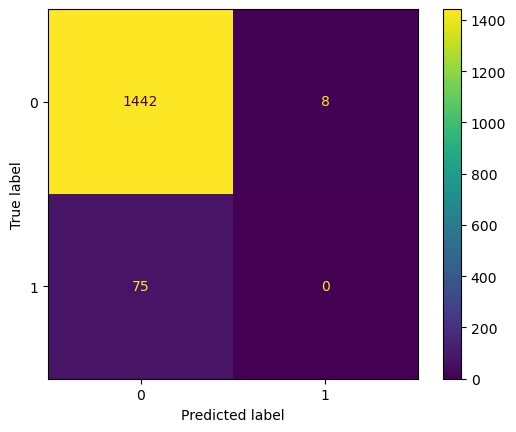

In [126]:
cm_benchmark = confusion_matrix(y_test, y_pred_benchmark)
disp = ConfusionMatrixDisplay(cm_benchmark)
disp.plot()

### **b. Optimized Treshold**

In [127]:
list_threshold = np.arange(0, 1, 0.01)
list_f1 = []

for threshold in list_threshold:
    
    # predict
    y_pred_proba = pipe_prep_model.predict_proba(X_test)[:, 1]
    y_pred_class = np.where(y_pred_proba > threshold, 1, 0)
    
    # f1 score
    list_f1.append(f1_score(y_test, y_pred_class))

# Dibuat dataframe dan diurutkan berdasarkan nilai 'f1'
df_threshold = pd.DataFrame()

df_threshold['threshold'] = list_threshold
df_threshold['f1'] = list_f1

df_threshold.sort_values('f1', ascending= False)



,threshold,f1
9,0.09,0.218543
10,0.10,0.218543
11,0.11,0.218543
12,0.12,0.218543
6,0.06,0.210210
...,...,...
62,0.62,0.000000
63,0.63,0.000000
64,0.64,0.000000
65,0.65,0.000000


Text(0, 0.5, 'f1')

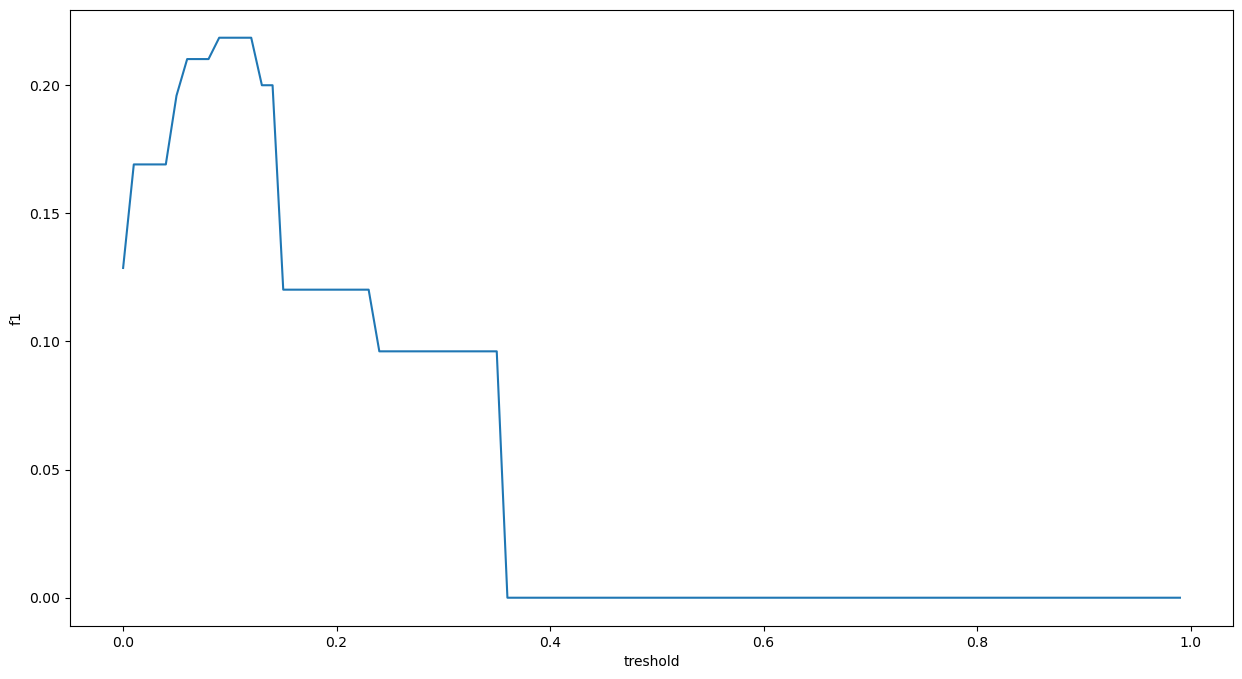

In [128]:
plt.figure(figsize=(15, 8))
sns.lineplot(data= df_threshold, x= 'threshold', y= 'f1')
plt.xlabel('treshold')
plt.ylabel('f1')

In [129]:
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('modeling', model)
])

pipe_prep_model.fit(X_train, y_train)

y_pred_proba = pipe_prep_model.predict_proba(X_test)[:, 1]
y_pred_class = np.where(y_pred_proba > 0.09, 1, 0)

f1_threshold = f1_score(y_test, y_pred_class)
print(f1_threshold)

recall_threshold = recall_score(y_test,y_pred_class)
print(recall_threshold)

0.2185430463576159
0.44


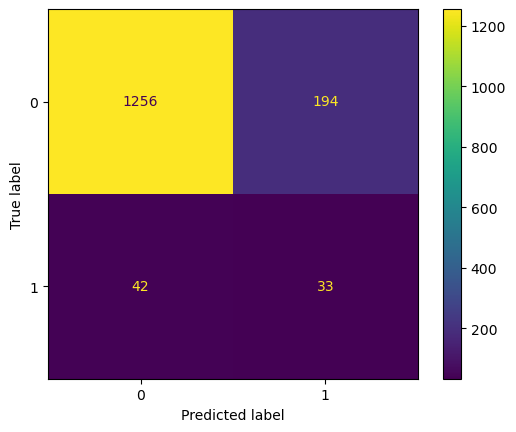

In [130]:
cm_benchmark = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(cm_benchmark)
disp.plot()

### **c. Random Oversamping**

In [131]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour
from imblearn.pipeline import Pipeline

In [132]:
ros = RandomOverSampler()

# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [133]:
pipe_prep_model = Pipeline([
    ('resampling', ros),
    ('preprocessing', transformer),
    ('modelling', model)
])

pipe_prep_model.fit(X_train, y_train)

y_pred_ros = pipe_prep_model.predict(X_test)

f1_ros = f1_score(y_test, y_pred_ros)
print(f1_ros)

recall_ros = recall_score(y_test,y_pred_ros)
print(recall_ros)

0.2019047619047619
0.7066666666666667


### **d. Random Undersampling**

In [134]:
rus = RandomUnderSampler(random_state= 0)

X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [135]:
pipe_prep_model = Pipeline([
    ('resampling', rus),
    ('preprocessing', transformer),
    ('modelling', model)
])

pipe_prep_model.fit(X_train, y_train)

y_pred_rus = pipe_prep_model.predict(X_test)

f1_rus = f1_score(y_test, y_pred_rus)
print(f1_rus)

recall_rus = recall_score(y_test,y_pred_rus)
print(recall_rus)

0.17454545454545456
0.64


### **e. NearM**

In [136]:
nearm = NearMiss(sampling_strategy='majority')

In [137]:
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', nearm),
    ('modelling', model)
])

pipe_prep_model.fit(X_train, y_train)

y_pred_nearm = pipe_prep_model.predict(X_test)

f1_nearm = f1_score(y_test, y_pred_nearm)
print(f1_nearm)

recall_nearm = recall_score(y_test,y_pred_nearm)
print(recall_nearm)

0.09803921568627451
0.6666666666666666


### **f. SMOTE**

In [138]:
smote = SMOTE(sampling_strategy= 'minority', random_state= 0)

In [139]:
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),
    ('resampling', smote),
    ('modelling', model)
])

pipe_prep_model.fit(X_train, y_train)

y_pred_smote = pipe_prep_model.predict(X_test)

f1_smote = f1_score(y_test, y_pred_smote)
print(f1_smote)

recall_smote = recall_score(y_test,y_pred_smote)
print(recall_smote)

0.19066937119675456
0.6266666666666667


In [140]:
print('Benchmark: ', f1_benchmark)
print('Optimized: ', f1_threshold)
print('Random OverSampling: ', f1_ros)
print('Random UnderSampling: ', f1_rus)
print('NearMiss: ', f1_nearm)
print('SMOTE: ', f1_smote)

print('-------------------')


print('Benchmark: ', recall_benchmark)
print('Optimized: ', recall_threshold)
print('Random OverSampling: ', recall_ros)
print('Random UnderSampling: ', recall_rus)
print('NearMiss: ', recall_nearm)
print('SMOTE: ', recall_smote)

Benchmark:  0.0
Optimized:  0.2185430463576159
Random OverSampling:  0.2019047619047619
Random UnderSampling:  0.17454545454545456
NearMiss:  0.09803921568627451
SMOTE:  0.19066937119675456
-------------------
Benchmark:  0.0
Optimized:  0.44
Random OverSampling:  0.7066666666666667
Random UnderSampling:  0.64
NearMiss:  0.6666666666666666
SMOTE:  0.6266666666666667


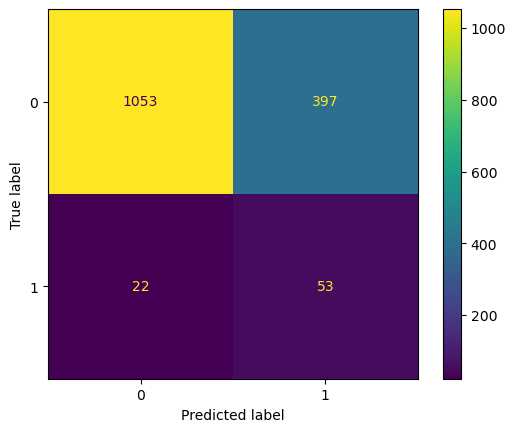

In [141]:
cm_benchmark = confusion_matrix(y_test, y_pred_ros)
disp = ConfusionMatrixDisplay(cm_benchmark)
disp.plot()


From this result, i will use decision tree algorithm with ROS treatment for data imbalanced and using recall as the metric

## **8. Cross Validation with Imbalanced Treatment**

In [142]:
logreg_ask = LogisticRegression(solver='liblinear', random_state=0)
knn_ask = KNeighborsClassifier(n_neighbors=5)
tree_ask = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, max_depth=5, random_state=0)

In [143]:
from sklearn.model_selection import StratifiedKFold
list_algo = [logreg_ask,knn_ask,tree_ask]
list_all_acc = []
list_mean_acc = []
list_std_acc =[]

for algo in list_algo :
    model = algo
    ros = RandomOverSampler()
    
    # pipeline 
    pipe_model = Pipeline([
    ('resampling', ros), 
    ('preprocessing',transformer),
    ('modeling', model )
    ])

    # define kfold 
    fold = StratifiedKFold(n_splits=5) 

    crossval = cross_val_score(estimator=pipe_model, # model 
                X = X_train,
                y = y_train,
                cv = fold, 
                scoring = 'recall',  
                error_score='raise')
    
    # accuracy 
    list_all_acc.append(crossval.round(5))
    list_mean_acc.append(crossval.mean())
    list_std_acc.append(crossval.std())

df_cv = pd.DataFrame()
df_cv['algo'] = list_algo
df_cv['all_score'] = list_all_acc
df_cv['mean'] = list_mean_acc
df_cv['std']= list_std_acc

df_cv

,algo,all_score,mean,std
0,"LogisticRegression(random_state=0, solver='lib...","[0.85714, 0.71429, 0.88235, 0.77143, 0.82857]",0.810756,0.060743
1,KNeighborsClassifier(),"[0.28571, 0.37143, 0.44118, 0.4, 0.25714]",0.351092,0.069313
2,"DecisionTreeClassifier(criterion='entropy', ma...","[0.88571, 0.77143, 0.76471, 0.71429, 0.82857]",0.792941,0.058861


## **9. Hyperparameter Tuning**

In [144]:
ros = RandomOverSampler(random_state=0)

# define model
model = LogisticRegression()

# pipeline 
pipe_model = Pipeline([
    ('resampling', ros), 
    ('preprocessing',transformer),
    ('modeling', model )
    ])

# hyperparameter space 
hyperparam_space = {
    'modeling__C':[100, 10, 1, 0.1, 0.01, 0.001],
    'modeling__solver':['liblinear','newton-cg']
}

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
grid_search = GridSearchCV(
    pipe_model, # model to tune
    param_grid = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1 # use all cores
)


In [145]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('resampling',
                                        RandomOverSampler(random_state=0)),
                                       ('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('mode_oneHot',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('modeOneHot',
                                                                                          OneHotEncoder(drop='first'))]...
                                                                                         ('robustKnn',
                                                                                          RobustScaler())]),
                                                                         ['bmi']),
                                                                        ('encoding',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['gender',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'Residence_type']),
                                                                        ('robustscale',
                                                                         RobustScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level'])])),
                                       ('modeling', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'modeling__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'modeling__solver': ['liblinear', 'newton-cg']},
             scoring='recall')

In [146]:
print('Best score:', grid_search.best_score_)
print('Best params:', grid_search.best_params_)

Best score: 0.8391596638655463
Best params: {'modeling__C': 0.001, 'modeling__solver': 'liblinear'}


## **10. Predict to Test Set**

Before Tuning

In [155]:
# define model
model = LogisticRegression()

# pipeline 
pipe_model = Pipeline([
    ('preprocessing',transformer),
    ('modeling', model )
])

# fit
pipe_model.fit(X_train,y_train)

# predict
y_pred_before = pipe_model.predict(X_test)
y_pred_before

# scoring
recall_score(y_test,y_pred_before)


0.013333333333333334

AFTER TUNING

In [156]:
# define model
model_final = grid_search.best_estimator_

# fit
model_final.fit(X_train, y_train)

# predict
y_pred_ros = model_final.predict(X_test)

# scoring
recall_ros = recall_score(y_test,y_pred_ros)
print(recall_ros)

0.7866666666666666


After testing several techniques for handling imbalanced data, the ROS technique was found to be the most suitable. Following the implementation of this imbalanced treatment, the logistic regression model yielded the best mean result. Upon prediction on the test set, it became evident that the imbalanced treatment significantly increased the recall score.